In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import joblib
import pickle
from pathlib import Path
from typing import Optional, Tuple, Dict, List
import warnings
from tqdm import tqdm
import time

In [2]:
df = pd.read_csv('tb2994_2D_info.csv')
df.tail

<bound method NDFrame.tail of         Unnamed: 0         0         1         2         3         4  \
0                0 -2.362560 -2.349261 -2.381622 -3.113331 -2.979651   
1                0 -2.622771 -3.139342 -1.947969 -3.294427 -2.647973   
2                0 -4.215792 -4.589001 -3.588621 -5.613833 -4.568493   
3                0 -3.632350 -4.411216 -2.250646 -4.327835 -2.829440   
4                0 -5.199796 -5.028620 -5.256289 -6.087603 -6.391552   
...            ...       ...       ...       ...       ...       ...   
139496         199 -3.156039 -5.355089 -2.638069 -3.490773 -2.427414   
139497         199 -4.164399 -3.228804 -2.362905 -5.419722 -0.708462   
139498         199 -3.225545 -0.688084 -1.379858 -4.588034 -0.115133   
139499         199 -0.945071  1.590981  0.015889 -3.077744  0.196195   
139500         199 -1.307818  2.579251  0.672690 -2.109503  0.649630   

               5         6         7         8  ...      1300      1301  \
0      -2.508979 -1.157565 -0.

In [7]:
#!/usr/bin/env python3
"""
Gaussian Mixture Model Analysis for Neural Embeddings - Notebook Version
Discovers discrete neural states during story comprehension using probabilistic clustering
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import joblib
import pickle
from pathlib import Path
from typing import Optional, Tuple, Dict, List
import warnings
from tqdm import tqdm
import time

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

class NeuralGMMAnalyzer:
    def __init__(self, cache_dir: Optional[str] = None):
        """
        Initialize GMM analyzer for neural embeddings

        Args:
            cache_dir: Optional directory to cache fitted models and results
        """
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir:
            self.cache_dir.mkdir(exist_ok=True)

        self.embeddings = None
        self.embeddings_scaled = None
        self.scaler = None
        self.models = {}
        self.model_scores = {}
        self.best_model = None
        self.best_n_components = None
        self.cluster_labels = None
        self.cluster_probabilities = None

    def load_embeddings(self, csv_path: str, sample_fraction: Optional[float] = None) -> None:
        """
        Load neural embeddings from CSV file

        Args:
            csv_path: Path to CSV file with embeddings
            sample_fraction: Optional fraction of data to sample for faster computation
        """
        print(f"Loading embeddings from {csv_path}...")

        # Load data
        self.embeddings = pd.read_csv(csv_path)
        print(f"Loaded embeddings: {self.embeddings.shape}")

        # Sample data if requested
        if sample_fraction and sample_fraction < 1.0:
            n_samples = int(len(self.embeddings) * sample_fraction)
            self.embeddings = self.embeddings.sample(n=n_samples, random_state=42).reset_index(drop=True)
            print(f"Sampled data: {self.embeddings.shape}")

        # Convert to numpy array for efficiency
        self.embeddings = self.embeddings.values

        # Standardize the data
        print("Standardizing embeddings...")
        self.scaler = StandardScaler()
        self.embeddings_scaled = self.scaler.fit_transform(self.embeddings)

        print(f"Final data shape: {self.embeddings_scaled.shape}")

    def fit_gmm_range(self, min_components: int = 2, max_components: int = 15,
                      covariance_type: str = 'full', random_state: int = 42,
                      n_init: int = 5) -> Dict[int, Dict]:
        """
        Fit GMM models for a range of component numbers and select best model

        Args:
            min_components: Minimum number of components to test
            max_components: Maximum number of components to test
            covariance_type: Type of covariance parameters ('full', 'tied', 'diag', 'spherical')
            random_state: Random state for reproducibility
            n_init: Number of initializations per model

        Returns:
            Dictionary with model scores and metrics
        """
        if self.embeddings_scaled is None:
            raise ValueError("Embeddings not loaded. Call load_embeddings() first.")

        print(f"Fitting GMM models for {min_components}-{max_components} components...")
        print(f"Data shape: {self.embeddings_scaled.shape}")

        n_components_range = range(min_components, max_components + 1)

        for n_components in tqdm(n_components_range, desc="Fitting GMM models"):
            # Check cache first
            cache_path = None
            if self.cache_dir:
                cache_path = self.cache_dir / f"gmm_{n_components}_{covariance_type}.joblib"
                if cache_path.exists():
                    print(f"Loading cached model for {n_components} components...")
                    gmm = joblib.load(cache_path)
                else:
                    gmm = self._fit_single_gmm(n_components, covariance_type, random_state, n_init)
                    joblib.dump(gmm, cache_path)
            else:
                gmm = self._fit_single_gmm(n_components, covariance_type, random_state, n_init)

            # Store model and compute scores
            self.models[n_components] = gmm

            # Compute various metrics
            labels = gmm.predict(self.embeddings_scaled)

            scores = {
                'aic': gmm.aic(self.embeddings_scaled),
                'bic': gmm.bic(self.embeddings_scaled),
                'log_likelihood': gmm.score(self.embeddings_scaled),
                'n_components': n_components,
                'converged': gmm.converged_
            }

            # Add silhouette score (computationally expensive for large datasets)
            if len(self.embeddings_scaled) <= 10000:
                scores['silhouette'] = silhouette_score(self.embeddings_scaled, labels)
                scores['calinski_harabasz'] = calinski_harabasz_score(self.embeddings_scaled, labels)

            self.model_scores[n_components] = scores

        # Select best model based on BIC (lower is better)
        best_n_by_bic = min(self.model_scores.keys(),
                            key=lambda k: self.model_scores[k]['bic'])

        self.best_n_components = best_n_by_bic
        self.best_model = self.models[best_n_by_bic]

        print(f"Best model: {best_n_by_bic} components (BIC: {self.model_scores[best_n_by_bic]['bic']:.2f})")

        return self.model_scores

    def _fit_single_gmm(self, n_components: int, covariance_type: str,
                        random_state: int, n_init: int) -> GaussianMixture:
        """Fit a single GMM model"""
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=random_state,
            n_init=n_init,
            max_iter=200
        )

        start_time = time.time()
        gmm.fit(self.embeddings_scaled)
        fit_time = time.time() - start_time

        if not gmm.converged_:
            print(f"Warning: GMM with {n_components} components did not converge")

        return gmm

    def predict_clusters(self, model: Optional[GaussianMixture] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Predict cluster assignments and probabilities

        Args:
            model: GMM model to use (defaults to best model)

        Returns:
            Tuple of (cluster_labels, cluster_probabilities)
        """
        if model is None:
            if self.best_model is None:
                raise ValueError("No model fitted. Call fit_gmm_range() first.")
            model = self.best_model

        print("Predicting cluster assignments...")
        self.cluster_labels = model.predict(self.embeddings_scaled)
        self.cluster_probabilities = model.predict_proba(self.embeddings_scaled)

        return self.cluster_labels, self.cluster_probabilities

    def plot_model_selection(self, save_path: Optional[str] = None) -> None:
        """Plot model selection criteria"""
        if not self.model_scores:
            raise ValueError("No models fitted. Call fit_gmm_range() first.")

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        n_components = list(self.model_scores.keys())
        aic_scores = [self.model_scores[k]['aic'] for k in n_components]
        bic_scores = [self.model_scores[k]['bic'] for k in n_components]
        log_likelihood = [self.model_scores[k]['log_likelihood'] for k in n_components]

        # AIC plot
        axes[0].plot(n_components, aic_scores, 'o-')
        axes[0].axvline(self.best_n_components, color='red', linestyle='--', alpha=0.7)
        axes[0].set_xlabel('Number of Components')
        axes[0].set_ylabel('AIC')
        axes[0].set_title('AIC Score')
        axes[0].grid(True, alpha=0.3)

        # BIC plot
        axes[1].plot(n_components, bic_scores, 'o-', color='orange')
        axes[1].axvline(self.best_n_components, color='red', linestyle='--', alpha=0.7)
        axes[1].set_xlabel('Number of Components')
        axes[1].set_ylabel('BIC')
        axes[1].set_title('BIC Score (Lower is Better)')
        axes[1].grid(True, alpha=0.3)

        # Log-likelihood plot
        axes[2].plot(n_components, log_likelihood, 'o-', color='green')
        axes[2].axvline(self.best_n_components, color='red', linestyle='--', alpha=0.7)
        axes[2].set_xlabel('Number of Components')
        axes[2].set_ylabel('Log-Likelihood')
        axes[2].set_title('Log-Likelihood (Higher is Better)')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Model selection plot saved to {save_path}")

        plt.show()

    def plot_clusters_pca(self, save_path: Optional[str] = None, n_samples_plot: int = 5000) -> None:
        """Plot clusters in 2D PCA space"""
        if self.cluster_labels is None:
            self.predict_clusters()

        # Sample data for plotting if dataset is large
        if len(self.embeddings_scaled) > n_samples_plot:
            indices = np.random.choice(len(self.embeddings_scaled), n_samples_plot, replace=False)
            embeddings_plot = self.embeddings_scaled[indices]
            labels_plot = self.cluster_labels[indices]
            print(f"Sampling {n_samples_plot} points for PCA visualization")
        else:
            embeddings_plot = self.embeddings_scaled
            labels_plot = self.cluster_labels

        # Compute PCA
        print("Computing PCA for visualization...")
        pca = PCA(n_components=2, random_state=42)
        embeddings_2d = pca.fit_transform(embeddings_plot)

        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                              c=labels_plot, cmap='tab10', alpha=0.6, s=1)
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f} variance)')
        plt.title(f'Neural Clusters in PCA Space ({self.best_n_components} clusters)')
        plt.grid(True, alpha=0.3)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"PCA cluster plot saved to {save_path}")

        plt.show()

        return pca, embeddings_2d

    def plot_cluster_timeline(self, save_path: Optional[str] = None, window_size: int = 100) -> None:
        """Plot cluster assignments over time (story progression)"""
        if self.cluster_labels is None:
            self.predict_clusters()

        # Smooth the cluster assignments using a rolling window
        n_timepoints = len(self.cluster_labels)
        timepoints = np.arange(n_timepoints)

        fig, axes = plt.subplots(2, 1, figsize=(15, 10))

        # Raw cluster assignments
        axes[0].scatter(timepoints, self.cluster_labels, alpha=0.3, s=0.5)
        axes[0].set_ylabel('Cluster')
        axes[0].set_title('Neural Cluster Assignments Over Story Time')
        axes[0].grid(True, alpha=0.3)

        # Smoothed cluster probabilities
        if window_size > 1 and window_size < n_timepoints:
            smoothed_probs = np.zeros((n_timepoints - window_size + 1, self.best_n_components))
            for i in range(n_timepoints - window_size + 1):
                window_probs = self.cluster_probabilities[i:i+window_size]
                smoothed_probs[i] = np.mean(window_probs, axis=0)

            for cluster in range(self.best_n_components):
                axes[1].plot(timepoints[:len(smoothed_probs)], smoothed_probs[:, cluster],
                             label=f'Cluster {cluster}', alpha=0.8)

            axes[1].set_xlabel('Time (token position)')
            axes[1].set_ylabel('Cluster Probability')
            axes[1].set_title(f'Smoothed Cluster Probabilities (window={window_size})')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Cluster timeline plot saved to {save_path}")

        plt.show()

    def get_cluster_statistics(self) -> Dict:
        """Get comprehensive statistics about discovered clusters"""
        if self.cluster_labels is None:
            self.predict_clusters()

        stats = {
            'n_clusters': self.best_n_components,
            'cluster_counts': {},
            'cluster_percentages': {},
            'uncertainty_stats': {},
            'transition_matrix': None
        }

        # Basic cluster statistics
        unique, counts = np.unique(self.cluster_labels, return_counts=True)
        for cluster, count in zip(unique, counts):
            stats['cluster_counts'][cluster] = count
            stats['cluster_percentages'][cluster] = count / len(self.cluster_labels) * 100

        # Uncertainty statistics (entropy of cluster probabilities)
        cluster_entropy = -np.sum(self.cluster_probabilities * np.log2(self.cluster_probabilities + 1e-10), axis=1)
        stats['uncertainty_stats'] = {
            'mean_entropy': np.mean(cluster_entropy),
            'std_entropy': np.std(cluster_entropy),
            'max_entropy': np.max(cluster_entropy),
            'high_uncertainty_pct': np.mean(cluster_entropy > np.percentile(cluster_entropy, 90)) * 100
        }

        # Transition matrix (how often clusters follow each other)
        n_clusters = self.best_n_components
        transition_matrix = np.zeros((n_clusters, n_clusters))

        for i in range(len(self.cluster_labels) - 1):
            current_cluster = self.cluster_labels[i]
            next_cluster = self.cluster_labels[i + 1]
            transition_matrix[current_cluster, next_cluster] += 1

        # Normalize to probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        transition_matrix = transition_matrix / row_sums

        stats['transition_matrix'] = transition_matrix

        return stats

    def save_results(self, output_dir: str) -> None:
        """Save all results to directory"""
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)

        # Save cluster assignments
        results_df = pd.DataFrame({
            'token_position': np.arange(len(self.cluster_labels)),
            'cluster': self.cluster_labels
        })

        # Add cluster probabilities
        for i in range(self.best_n_components):
            results_df[f'cluster_{i}_prob'] = self.cluster_probabilities[:, i]

        results_df.to_csv(output_path / 'cluster_assignments.csv', index=False)

        # Save model scores
        scores_df = pd.DataFrame(self.model_scores).T
        scores_df.to_csv(output_path / 'model_selection_scores.csv')

        # Save best model
        joblib.dump(self.best_model, output_path / 'best_gmm_model.joblib')
        joblib.dump(self.scaler, output_path / 'scaler.joblib')

        # Save statistics
        stats = self.get_cluster_statistics()
        with open(output_path / 'cluster_statistics.json', 'w') as f:
            import json
            # Convert numpy types to native Python types for JSON serialization
            stats_json = self._convert_numpy_types(stats)
            json.dump(stats_json, f, indent=2)

        print(f"Results saved to {output_path}/")

    def _convert_numpy_types(self, obj):
        """Recursively convert numpy types to Python native types for JSON serialization"""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {str(key): self._convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self._convert_numpy_types(item) for item in obj]
        else:
            return obj


# =============================================================================
# NOTEBOOK USAGE FUNCTION
# =============================================================================

def analyze_neural_clusters(csv_path, min_components=2, max_components=15,
                            cache_dir=None, output_dir=None, sample_fraction=None,
                            plot_pca=True, plot_timeline=True, plot_model_selection=True,
                            save_plots=False, plot_dir="./plots/"):
    """
    Complete neural clustering analysis workflow for notebook use.

    Args:
        csv_path (str): Path to CSV file with neural embeddings
        min_components (int): Minimum number of clusters to test
        max_components (int): Maximum number of clusters to test
        cache_dir (str, optional): Directory to cache fitted models
        output_dir (str, optional): Directory to save all results
        sample_fraction (float, optional): Fraction of data to sample for faster computation
        plot_pca (bool): Whether to show PCA cluster visualization
        plot_timeline (bool): Whether to show cluster timeline
        plot_model_selection (bool): Whether to show model selection plots
        save_plots (bool): Whether to save plots to files
        plot_dir (str): Directory to save plots if save_plots=True

    Returns:
        tuple: (analyzer, cluster_labels, cluster_probabilities, statistics)

    Example usage in notebook:
        # Basic analysis
        analyzer, labels, probs, stats = analyze_neural_clusters('neural_embeddings.csv')

        # With caching and output saving
        analyzer, labels, probs, stats = analyze_neural_clusters(
            'neural_embeddings.csv',
            cache_dir='./cache/',
            output_dir='./results/',
            max_components=12,
            save_plots=True
        )

        # For large datasets - sample for faster computation
        analyzer, labels, probs, stats = analyze_neural_clusters(
            'neural_embeddings.csv',
            sample_fraction=0.1,  # Use 10% of data
            max_components=10
        )
    """
    # Initialize analyzer
    analyzer = NeuralGMMAnalyzer(cache_dir=cache_dir)

    # Load data
    analyzer.load_embeddings(csv_path, sample_fraction=sample_fraction)

    # Fit models and select best
    print(f"\nFitting GMM models ({min_components}-{max_components} components)...")
    model_scores = analyzer.fit_gmm_range(min_components, max_components)

    # Get cluster assignments
    cluster_labels, cluster_probabilities = analyzer.predict_clusters()

    # Generate statistics
    statistics = analyzer.get_cluster_statistics()

    # Print summary
    print(f"\n" + "="*60)
    print("NEURAL CLUSTERING ANALYSIS SUMMARY")
    print("="*60)
    print(f"Best model: {analyzer.best_n_components} clusters")
    print(f"Data shape: {analyzer.embeddings_scaled.shape}")
    print(f"Cluster distribution:")
    for cluster, pct in statistics['cluster_percentages'].items():
        print(f"  Cluster {cluster}: {statistics['cluster_counts'][cluster]} tokens ({pct:.1f}%)")
    print(f"Mean uncertainty (entropy): {statistics['uncertainty_stats']['mean_entropy']:.3f}")
    print(f"High uncertainty tokens: {statistics['uncertainty_stats']['high_uncertainty_pct']:.1f}%")

    # Create plots directory if saving
    if save_plots:
        Path(plot_dir).mkdir(exist_ok=True)

    # Generate plots
    if plot_model_selection:
        save_path = f"{plot_dir}/model_selection.png" if save_plots else None
        analyzer.plot_model_selection(save_path)

    if plot_pca:
        save_path = f"{plot_dir}/clusters_pca.png" if save_plots else None
        analyzer.plot_clusters_pca(save_path)

    if plot_timeline:
        save_path = f"{plot_dir}/cluster_timeline.png" if save_plots else None
        analyzer.plot_cluster_timeline(save_path)

    # Save results if requested
    if output_dir:
        analyzer.save_results(output_dir)

    return analyzer, cluster_labels, cluster_probabilities, statistics


# =============================================================================
# QUICK START EXAMPLES FOR NOTEBOOK
# =============================================================================

"""
# Example 1: Basic neural clustering analysis
analyzer, labels, probs, stats = analyze_neural_clusters('neural_embeddings.csv')

# Example 2: Advanced analysis with caching and full outputs
analyzer, labels, probs, stats = analyze_neural_clusters(
    'neural_embeddings.csv',
    min_components=3,
    max_components=12,
    cache_dir='./gmm_cache/',
    output_dir='./clustering_results/',
    save_plots=True,
    plot_dir='./clustering_plots/'
)

# Example 3: For large datasets - use sampling
analyzer, labels, probs, stats = analyze_neural_clusters(
    'neural_embeddings.csv',
    sample_fraction=0.2,  # Use 20% of data for faster computation
    max_components=10
)

# Example 4: Access specific results
print(f"Number of discovered clusters: {stats['n_clusters']}")
print(f"Transition matrix shape: {stats['transition_matrix'].shape}")

# Find high-uncertainty timepoints
uncertainty = -np.sum(probs * np.log2(probs + 1e-10), axis=1)
high_uncertainty_indices = np.where(uncertainty > np.percentile(uncertainty, 95))[0]
print(f"High uncertainty timepoints: {high_uncertainty_indices}")

# Example 5: Custom analysis with saved analyzer
# Load previously saved model
# best_model = joblib.load('clustering_results/best_gmm_model.joblib')
# scaler = joblib.load('clustering_results/scaler.joblib')

# Apply to new data
# new_data_scaled = scaler.transform(new_data)
# new_labels = best_model.predict(new_data_scaled)
"""

'\n# Example 1: Basic neural clustering analysis\nanalyzer, labels, probs, stats = analyze_neural_clusters(\'neural_embeddings.csv\')\n\n# Example 2: Advanced analysis with caching and full outputs\nanalyzer, labels, probs, stats = analyze_neural_clusters(\n    \'neural_embeddings.csv\',\n    min_components=3,\n    max_components=12,\n    cache_dir=\'./gmm_cache/\',\n    output_dir=\'./clustering_results/\',\n    save_plots=True,\n    plot_dir=\'./clustering_plots/\'\n)\n\n# Example 3: For large datasets - use sampling\nanalyzer, labels, probs, stats = analyze_neural_clusters(\n    \'neural_embeddings.csv\',\n    sample_fraction=0.2,  # Use 20% of data for faster computation\n    max_components=10\n)\n\n# Example 4: Access specific results\nprint(f"Number of discovered clusters: {stats[\'n_clusters\']}")\nprint(f"Transition matrix shape: {stats[\'transition_matrix\'].shape}")\n\n# Find high-uncertainty timepoints\nuncertainty = -np.sum(probs * np.log2(probs + 1e-10), axis=1)\nhigh_unce

Loading embeddings from tb2994_2D_info.csv...
Loaded embeddings: (139501, 1311)
Sampled data: (6975, 1311)
Standardizing embeddings...
Final data shape: (6975, 1311)

Fitting GMM models (2-8 components)...
Fitting GMM models for 2-8 components...
Data shape: (6975, 1311)


Fitting GMM models:   0%|          | 0/7 [00:00<?, ?it/s]

Loading cached model for 2 components...


Fitting GMM models:  14%|█▍        | 1/7 [00:00<00:05,  1.11it/s]

Loading cached model for 3 components...


Fitting GMM models: 100%|██████████| 7/7 [02:09<00:00, 18.46s/it]


Best model: 4 components (BIC: 29866776.72)
Predicting cluster assignments...

NEURAL CLUSTERING ANALYSIS SUMMARY
Best model: 4 clusters
Data shape: (6975, 1311)
Cluster distribution:
  Cluster 0: 1110 tokens (15.9%)
  Cluster 1: 3350 tokens (48.0%)
  Cluster 2: 2049 tokens (29.4%)
  Cluster 3: 466 tokens (6.7%)
Mean uncertainty (entropy): -0.000
High uncertainty tokens: 0.1%
Model selection plot saved to ./gmm_plots//model_selection.png


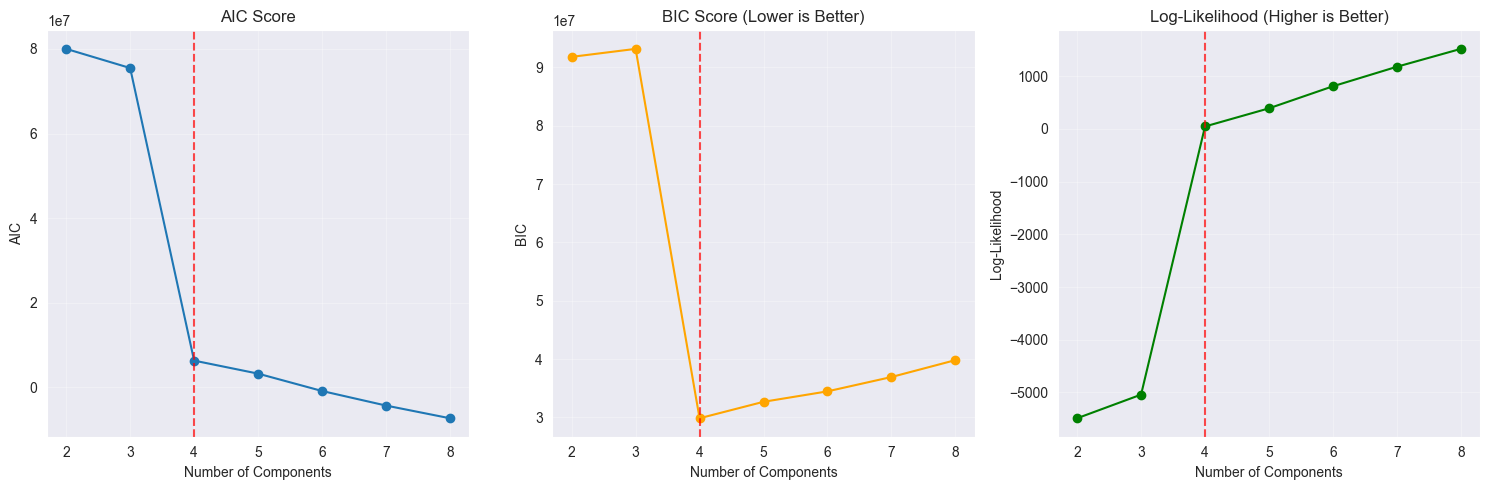

Sampling 5000 points for PCA visualization
Computing PCA for visualization...
PCA cluster plot saved to ./gmm_plots//clusters_pca.png


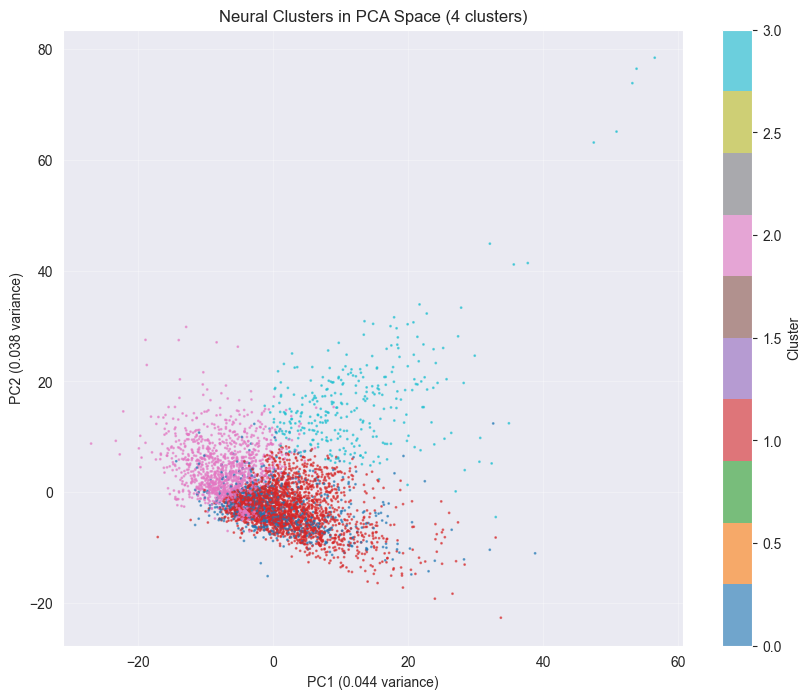

Cluster timeline plot saved to ./gmm_plots//cluster_timeline.png


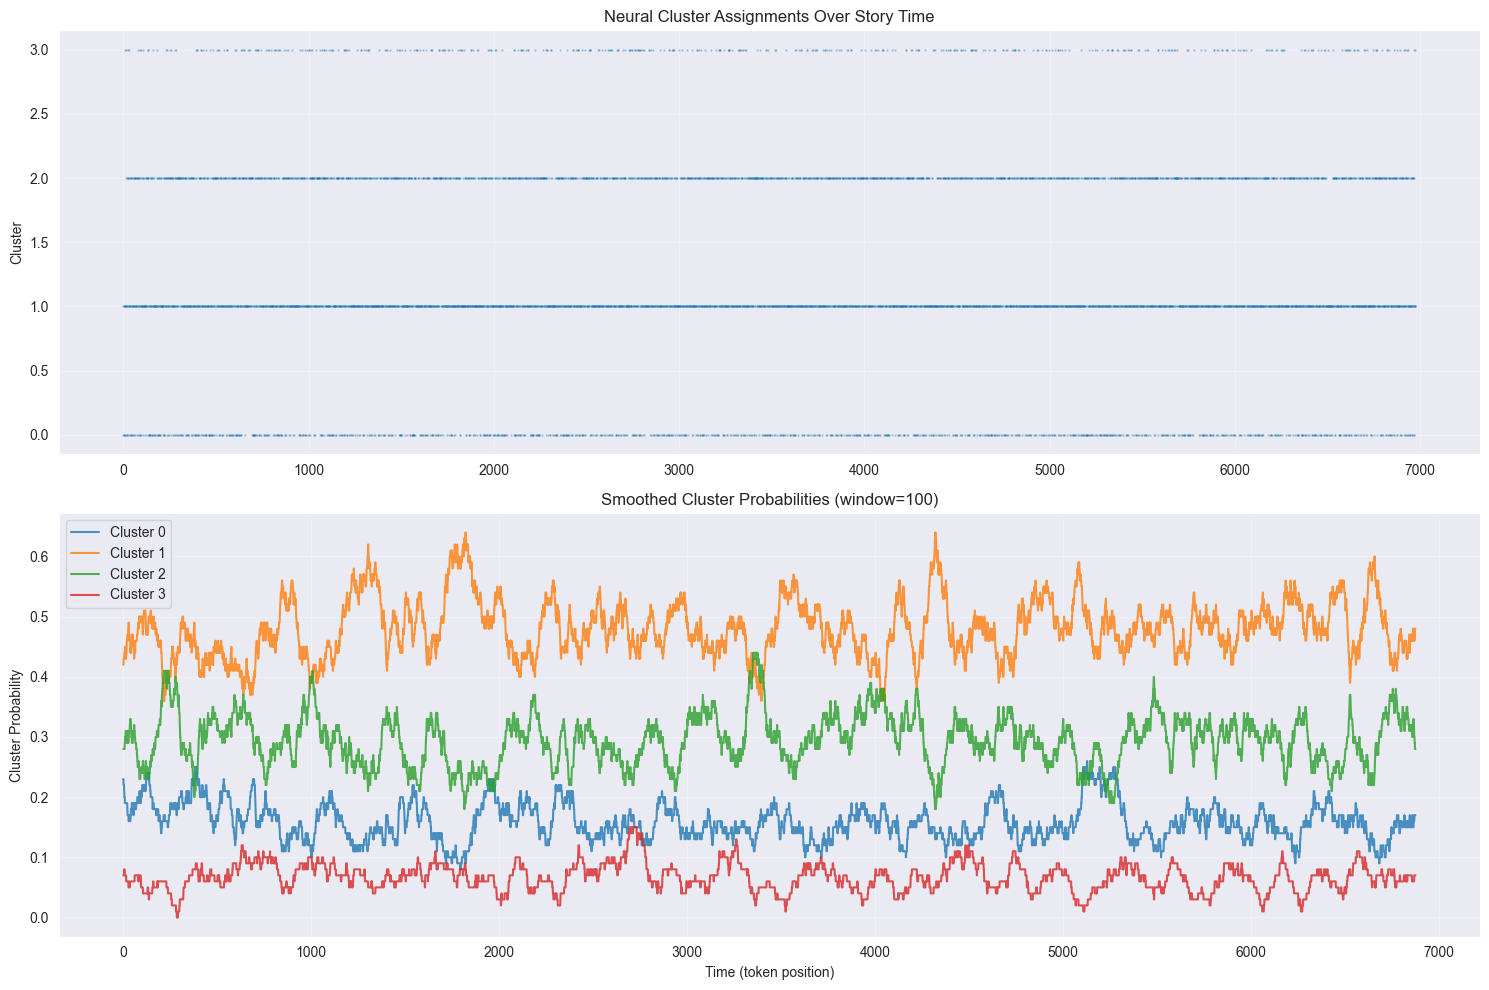

Results saved to gmm_results/


In [12]:
analyzer, labels, probs, stats = analyze_neural_clusters(
    'tb2994_2D_info.csv',
    sample_fraction=0.05,
    max_components=8,
    cache_dir='./gmm_cache/',
    output_dir='./gmm_results/',
    save_plots=True,
    plot_dir='./gmm_plots/'
)